# Anomaly Detection in Sensor Data
In semiconductor industry, a wafer goes through fabrication process that involves various tools, and a recipe defines how the wafer is processed by a tool. A wafer lot is a batch of multiple wafers that belong to the same technology and product.

The sensor values of a tool are recorded for each wafer run, and this data is important for engineers to determine if the tool is working properly or not. Therefore, an FDC (fault detection and classification) system is necessary to detect any tool sensor anomalies to prevent further wafer scraps.

The CSV file contains the wafer run information (e.g. TimeStamp, ToolName), and the columns with randomized characters denote the sensors.

Data: Tool_Sensor_Data.csv

## Table of Contents
1. Import Libraries
2. Load Data
3. Data Cleaning
4. Exploratory Data Analysis
5. Anomaly Detection
6. Results

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer

import shap

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
plt.style.use('seaborn-white')

/Users/plthon/miniforge3/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/plthon/miniforge3/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_mask

# Load Data

In [2]:
df = pd.read_csv('Tool_Sensor_Data.csv')
df.head(10)

TimeStamp ToolName TOOL_ID    Run RunStartTime  DATA_QUALITY EQPType  \
0  21/3/2023 19:14        A       A  62301  12:14:19 AM         63.49       A   
1  21/3/2023 19:14        A       A  62301  12:14:19 AM         63.49       A   
2  21/3/2023 19:14        A       A  62301  12:14:19 AM         63.49       A   
3  21/3/2023 19:14        A       A  62301  12:14:19 AM         63.49       A   
4  21/3/2023 19:14        A       A  62301  12:14:19 AM         63.49       A   
5  21/3/2023 19:14        A       A  62301  12:14:19 AM         63.49       A   
6  21/3/2023 19:15        A       A  62301  12:14:19 AM         63.49       A   
7  21/3/2023 19:15        A       A  62301  12:14:19 AM         63.49       A   
8  21/3/2023 19:15        A       A  62301  12:14:19 AM         63.49       A   
9  21/3/2023 19:15        A       A  62301  12:14:19 AM         63.49       A   

   HasComments LOT_ID LogicalRecipeID  ... yqScxEFPLde jrsnDLYHnMHD  \
0            0      A               A  ...         NaN          NaN   
1            0      A               A  ...         NaN          NaN   
2            0      A               A  ...         NaN          NaN   
3            0      A               A  ...         NaN          NaN   
4            0      A               A  ...         NaN          NaN   
5            0      A               A  ...         NaN          NaN   
6            0      A               A  ...         NaN          NaN   
7            0      A               A  ...         NaN          NaN   
8            0      A               A  ...         NaN          NaN   
9            0      A               A  ...         NaN          NaN   

  CalcStepSeq CalcLoopSeq RunTag Unnamed: 85 Unnamed: 86 Unnamed: 87  \
0         NaN         NaN    NaN         NaN         NaN         NaN   
1         1.0         1.0    NaN         NaN         NaN         NaN   
2         2.0         2.0    NaN         NaN         NaN         NaN   
3         3.0         3.0    NaN         NaN         NaN         NaN   
4         4.0         4.0    NaN         NaN         NaN         NaN   
5         5.0         5.0    NaN         NaN         NaN         NaN   
6         5.0         5.0    NaN         NaN         NaN         NaN   
7         5.0         5.0    NaN         NaN         NaN         NaN   
8         5.0         5.0    NaN         NaN         NaN         NaN   
9         5.0         5.0    NaN         NaN         NaN         NaN   

  Unnamed: 88  Unnamed: 89  
0         NaN          NaN  
1         NaN          NaN  
2         NaN          NaN  
3         NaN          NaN  
4         NaN          NaN  
5         NaN          NaN  
6         NaN          NaN  
7         NaN          NaN  
8         NaN          NaN  
9         NaN          NaN  

[10 rows x 90 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14844 entries, 0 to 14843
Data columns (total 90 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   TimeStamp                     14844 non-null  object 
 1   ToolName                      14844 non-null  object 
 2   TOOL_ID                       14844 non-null  object 
 3   Run                           14844 non-null  int64  
 4   RunStartTime                  14844 non-null  object 
 5   DATA_QUALITY                  14844 non-null  float64
 6   EQPType                       14844 non-null  object 
 7   HasComments                   14844 non-null  int64  
 8   LOT_ID                        14844 non-null  object 
 9   LogicalRecipeID               14844 non-null  object 
 10  LotPurposeType                14844 non-null  object 
 11  LotType                       14844 non-null  object 
 12  MachineRecipeID               14844 non-null  object 
 13  P

In [4]:
df.describe()

Run  DATA_QUALITY  HasComments  ReticleID      WAFER_ID  \
count  14844.000000  14844.000000      14844.0        0.0  14844.000000   
mean   62437.529103     70.762264          0.0        NaN     12.707154   
std       90.607731     15.702130          0.0        NaN      7.111389   
min    62301.000000     42.330000          0.0        NaN      1.000000   
25%    62359.000000     58.560000          0.0        NaN      6.750000   
50%    62408.000000     63.890000          0.0        NaN     13.000000   
75%    62528.000000     89.710000          0.0        NaN     19.000000   
max    62600.000000    100.000000          0.0        NaN     25.000000   

       OunhHslCRwIRilo    iezpXSIRyQ  GPTmghByqMSY  pZXcGFNpzPf    BmpcKiosIw  \
count     14388.000000  1.438800e+04       14388.0      14388.0  14388.000000   
mean        115.818807  9.800000e-01           1.0          1.0      5.817178   
std          54.891018  3.330785e-16           0.0          0.0      5.575780   
min          10.000000  9.800000e-01           1.0          1.0      0.410000   
25%          91.000000  9.800000e-01           1.0          1.0      4.420000   
50%         144.000000  9.800000e-01           1.0          1.0      4.920000   
75%         157.000000  9.800000e-01           1.0          1.0      7.140000   
max         165.000000  9.800000e-01           1.0          1.0     72.530000   

       ...  yqScxEFPLde  jrsnDLYHnMHD   CalcStepSeq   CalcLoopSeq  RunTag  \
count  ...          0.0           0.0  14616.000000  14616.000000     0.0   
mean   ...          NaN           NaN      6.289135      6.289135     NaN   
std    ...          NaN           NaN      3.097085      3.097085     NaN   
min    ...          NaN           NaN     -1.000000     -1.000000     NaN   
25%    ...          NaN           NaN      4.000000      4.000000     NaN   
50%    ...          NaN           NaN      6.000000      6.000000     NaN   
75%    ...          NaN           NaN      8.000000      8.000000     NaN   
max    ...          NaN           NaN     17.000000     17.000000     NaN   

       Unnamed: 85  Unnamed: 86  Unnamed: 87  Unnamed: 88  Unnamed: 89  
count          0.0          0.0          0.0          0.0          0.0  
mean           NaN          NaN          NaN          NaN          NaN  
std            NaN          NaN          NaN          NaN          NaN  
min            NaN          NaN          NaN          NaN          NaN  
25%            NaN          NaN          NaN          NaN          NaN  
50%            NaN          NaN          NaN          NaN          NaN  
75%            NaN          NaN          NaN          NaN          NaN  
max            NaN          NaN          NaN          NaN          NaN  

[8 rows x 69 columns]

In [5]:
df.describe(include='object')

TimeStamp ToolName TOOL_ID RunStartTime EQPType LOT_ID  \
count            14844    14844   14844        14844   14844  14844   
unique             921        1       1          222       1     23   
top     22/3/2023 3:27        A       A  12:29:03 AM       A      G   
freq                39    14844   14844          140   14844   2060   

       LogicalRecipeID LotPurposeType     LotType MachineRecipeID  ... PortID  \
count            14844          14844       14844           14844  ...  14844   
unique               1              1           1               2  ...      2   
top                  A    Process Lot  Production               A  ...      A   
freq             14844          14844       14844           11592  ...   8603   

       ProcessOpNum ProductGrpID ProductID RECIPE_ID RouteID Technology  \
count         14844        14844     14844     14844   14844      14844   
unique            6           14        16         2      12          5   
top               A            C         C         A       C          C   
freq           6831         4834      4834     14819    5311       5763   

       EventType   EventName     EventId  
count        456         456         456  
unique         2           2           2  
top     EndOfRun  WaferStart  WaferStart  
freq         228         228         228  

[4 rows x 21 columns]

In [6]:
print(df.columns)

Index(['TimeStamp', 'ToolName', 'TOOL_ID', 'Run', 'RunStartTime',
       'DATA_QUALITY', 'EQPType', 'HasComments', 'LOT_ID', 'LogicalRecipeID',
       'LotPurposeType', 'LotType', 'MachineRecipeID', 'PhysicalRecipeID',
       'PortID', 'ProcessOpNum', 'ProductGrpID', 'ProductID', 'RECIPE_ID',
       'ReticleID', 'RouteID', 'Technology', 'WAFER_ID', 'OunhHslCRwIRilo',
       'iezpXSIRyQ', 'GPTmghByqMSY', 'pZXcGFNpzPf', 'BmpcKiosIw', 'XnKsCBLOqH',
       'GEErHMkWtLOrD', 'ATisLDMDDfZrI', 'ZhitvZfLGQzyC', 'SwpYipezsdueC',
       'YiAwOaAhwskZcEfg', 'CxPgKZCqQsFtMQZdEkFTQ',
       'EcBnlzqiTwFxSSBTvYsYOOaCax', 'UYmpqidlVJQGSXnENDNUVUTbp',
       'QveHzspDQenotLMRwWdjK', 'tzEiBNrESroInUjAStFCzgiCYU',
       'OeFBBIdvVlvVTeDufgEbQZtuB', 'TyPUktVeQlH', 'ArsbiQzICA', 'ueAWtcWKJJ',
       'WLGtKKqZiN', 'EHVtYhnRGb', 'YffEHvEJjM', 'TNfKYBQBdc',
       'ETYSQPkJNbQsmWtwf', 'dCEQyYYpj', 'taQyPEGv', 'XSOeMfJAB', 'SYklrMAXe',
       'jQVGDTFl', 'YDlkDLfFEEi', 'CYiycrAoYbg', 'oUWQRhjudAd', 'dSqlDZohV

In [7]:
# Check for missing values
df.isnull().sum()

TimeStamp           0
ToolName            0
TOOL_ID             0
Run                 0
RunStartTime        0
                ...  
Unnamed: 85     14844
Unnamed: 86     14844
Unnamed: 87     14844
Unnamed: 88     14844
Unnamed: 89     14844
Length: 90, dtype: int64

# Data Cleaning

We will drop all columns where all elements are NaN and all columns with only one unique value (all elements are the same).

In [8]:
# Drop all columns where all elements are NaN
df = df.dropna(axis=1, how='all')

# Drop all columns with only one unique value
# df = df.loc[:,df.apply(pd.Series.nunique) != 1]
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14844 entries, 0 to 14843
Data columns (total 66 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   TimeStamp                     14844 non-null  object 
 1   Run                           14844 non-null  int64  
 2   RunStartTime                  14844 non-null  object 
 3   DATA_QUALITY                  14844 non-null  float64
 4   LOT_ID                        14844 non-null  object 
 5   MachineRecipeID               14844 non-null  object 
 6   PhysicalRecipeID              14844 non-null  object 
 7   PortID                        14844 non-null  object 
 8   ProcessOpNum                  14844 non-null  object 
 9   ProductGrpID                  14844 non-null  object 
 10  ProductID                     14844 non-null  object 
 11  RECIPE_ID                     14844 non-null  object 
 12  RouteID                       14844 non-null  object 
 13  T

In [9]:
df.head(10)

TimeStamp    Run RunStartTime  DATA_QUALITY LOT_ID MachineRecipeID  \
0  21/3/2023 19:14  62301  12:14:19 AM         63.49      A               A   
1  21/3/2023 19:14  62301  12:14:19 AM         63.49      A               A   
2  21/3/2023 19:14  62301  12:14:19 AM         63.49      A               A   
3  21/3/2023 19:14  62301  12:14:19 AM         63.49      A               A   
4  21/3/2023 19:14  62301  12:14:19 AM         63.49      A               A   
5  21/3/2023 19:14  62301  12:14:19 AM         63.49      A               A   
6  21/3/2023 19:15  62301  12:14:19 AM         63.49      A               A   
7  21/3/2023 19:15  62301  12:14:19 AM         63.49      A               A   
8  21/3/2023 19:15  62301  12:14:19 AM         63.49      A               A   
9  21/3/2023 19:15  62301  12:14:19 AM         63.49      A               A   

  PhysicalRecipeID PortID ProcessOpNum ProductGrpID  ... QesumGN ETcatZBXS  \
0                A      A            A            A  ...     NaN       NaN   
1                A      A            A            A  ...     2.0     500.0   
2                A      A            A            A  ...     7.0     300.0   
3                A      A            A            A  ...     8.0     300.0   
4                A      A            A            A  ...     9.0    6200.0   
5                A      A            A            A  ...    11.0    1400.0   
6                A      A            A            A  ...    11.0    9800.0   
7                A      A            A            A  ...    11.0   11300.0   
8                A      A            A            A  ...    11.0   11300.0   
9                A      A            A            A  ...    11.0   14500.0   

  RnVvcKsHhDEyb tMqophNywoUtXsGZAeVHBvtFjuyM  WTcLPnkDtRwBuCou   EventType  \
0           NaN                          NaN               NaN  StartOfRun   
1          81.0                        -25.0              75.0         NaN   
2          81.0                       1890.0              75.0         NaN   
3          81.0                       1890.0              75.0         NaN   
4          81.0                       1890.0              75.0         NaN   
5          81.0                       1890.0              75.0         NaN   
6          81.0                       1890.0              75.0         NaN   
7          81.0                       1890.0              75.0         NaN   
8          81.0                       1890.0              75.0         NaN   
9          81.0                       1890.0              75.0         NaN   

    EventName     EventId  CalcStepSeq  CalcLoopSeq  
0  WaferStart  WaferStart          NaN          NaN  
1         NaN         NaN          1.0          1.0  
2         NaN         NaN          2.0          2.0  
3         NaN         NaN          3.0          3.0  
4         NaN         NaN          4.0          4.0  
5         NaN         NaN          5.0          5.0  
6         NaN         NaN          5.0          5.0  
7         NaN         NaN          5.0          5.0  
8         NaN         NaN          5.0          5.0  
9         NaN         NaN          5.0          5.0  

[10 rows x 66 columns]

We will drop all rows where the EventType is StartOfRun or EndOfRun. These rows do not contain any sensor values.

In [10]:
df['EventType'].unique()

array(['StartOfRun', nan, 'EndOfRun'], dtype=object)

In [11]:
df = df[(df['EventType'] != 'StartOfRun') & (df['EventType'] != 'EndOfRun')]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14388 entries, 1 to 14842
Data columns (total 66 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   TimeStamp                     14388 non-null  object 
 1   Run                           14388 non-null  int64  
 2   RunStartTime                  14388 non-null  object 
 3   DATA_QUALITY                  14388 non-null  float64
 4   LOT_ID                        14388 non-null  object 
 5   MachineRecipeID               14388 non-null  object 
 6   PhysicalRecipeID              14388 non-null  object 
 7   PortID                        14388 non-null  object 
 8   ProcessOpNum                  14388 non-null  object 
 9   ProductGrpID                  14388 non-null  object 
 10  ProductID                     14388 non-null  object 
 11  RECIPE_ID                     14388 non-null  object 
 12  RouteID                       14388 non-null  object 
 13  T

In [12]:
# Drop EventType, EventName and EventId columns
df = df.drop(['EventType', 'EventName', 'EventId'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14388 entries, 1 to 14842
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   TimeStamp                     14388 non-null  object 
 1   Run                           14388 non-null  int64  
 2   RunStartTime                  14388 non-null  object 
 3   DATA_QUALITY                  14388 non-null  float64
 4   LOT_ID                        14388 non-null  object 
 5   MachineRecipeID               14388 non-null  object 
 6   PhysicalRecipeID              14388 non-null  object 
 7   PortID                        14388 non-null  object 
 8   ProcessOpNum                  14388 non-null  object 
 9   ProductGrpID                  14388 non-null  object 
 10  ProductID                     14388 non-null  object 
 11  RECIPE_ID                     14388 non-null  object 
 12  RouteID                       14388 non-null  object 
 13  T

We will drop all columns with only one unique value again.

In [13]:
# Drop all columns with only one unique value again
# df = df.loc[:,df.apply(pd.Series.nunique) != 1]
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14388 entries, 1 to 14842
Data columns (total 50 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   TimeStamp                     14388 non-null  object 
 1   Run                           14388 non-null  int64  
 2   RunStartTime                  14388 non-null  object 
 3   DATA_QUALITY                  14388 non-null  float64
 4   LOT_ID                        14388 non-null  object 
 5   MachineRecipeID               14388 non-null  object 
 6   PhysicalRecipeID              14388 non-null  object 
 7   PortID                        14388 non-null  object 
 8   ProcessOpNum                  14388 non-null  object 
 9   ProductGrpID                  14388 non-null  object 
 10  ProductID                     14388 non-null  object 
 11  RECIPE_ID                     14388 non-null  object 
 12  RouteID                       14388 non-null  object 
 13  T

Columns with randomized characters denote the sensors. We will separate the sensors from the other columns.

In [14]:
columns = df.columns

# Get the first 15 and last 5 column names
first_15_columns = columns[:15]
last_5_columns = columns[-2:]
others = first_15_columns.append(last_5_columns)

# Get the remaining columns
sensors = columns[15:-2]

# Print the column lists
print("others:")
print(others)
print()
print("sensors:")
print(sensors)

others:
Index(['TimeStamp', 'Run', 'RunStartTime', 'DATA_QUALITY', 'LOT_ID',
       'MachineRecipeID', 'PhysicalRecipeID', 'PortID', 'ProcessOpNum',
       'ProductGrpID', 'ProductID', 'RECIPE_ID', 'RouteID', 'Technology',
       'WAFER_ID', 'CalcStepSeq', 'CalcLoopSeq'],
      dtype='object')

sensors:
Index(['OunhHslCRwIRilo', 'BmpcKiosIw', 'XnKsCBLOqH', 'GEErHMkWtLOrD',
       'ATisLDMDDfZrI', 'ZhitvZfLGQzyC', 'SwpYipezsdueC', 'YiAwOaAhwskZcEfg',
       'CxPgKZCqQsFtMQZdEkFTQ', 'EcBnlzqiTwFxSSBTvYsYOOaCax',
       'UYmpqidlVJQGSXnENDNUVUTbp', 'QveHzspDQenotLMRwWdjK',
       'tzEiBNrESroInUjAStFCzgiCYU', 'OeFBBIdvVlvVTeDufgEbQZtuB',
       'TyPUktVeQlH', 'ArsbiQzICA', 'ueAWtcWKJJ', 'WLGtKKqZiN', 'YffEHvEJjM',
       'TNfKYBQBdc', 'ETYSQPkJNbQsmWtwf', 'dCEQyYYpj', 'dSqlDZohVx',
       'pIzvhgujbH', 'XAsiHMsvPv', 'RUNSjtpEAy', 'YATWcaRqpB', 'nJdvUmCcjI',
       'NACdQXDDBP', 'QesumGN', 'ETcatZBXS', 'RnVvcKsHhDEyb',
       'tMqophNywoUtXsGZAeVHBvtFjuyM'],
      dtype='object')


# Exploratory Data Analysis

In [15]:
df.head(10)

TimeStamp    Run RunStartTime  DATA_QUALITY LOT_ID MachineRecipeID  \
1   21/3/2023 19:14  62301  12:14:19 AM         63.49      A               A   
2   21/3/2023 19:14  62301  12:14:19 AM         63.49      A               A   
3   21/3/2023 19:14  62301  12:14:19 AM         63.49      A               A   
4   21/3/2023 19:14  62301  12:14:19 AM         63.49      A               A   
5   21/3/2023 19:14  62301  12:14:19 AM         63.49      A               A   
6   21/3/2023 19:15  62301  12:14:19 AM         63.49      A               A   
7   21/3/2023 19:15  62301  12:14:19 AM         63.49      A               A   
8   21/3/2023 19:15  62301  12:14:19 AM         63.49      A               A   
9   21/3/2023 19:15  62301  12:14:19 AM         63.49      A               A   
10  21/3/2023 19:15  62301  12:14:19 AM         63.49      A               A   

   PhysicalRecipeID PortID ProcessOpNum ProductGrpID  ... RUNSjtpEAy  \
1                 A      A            A            A  ...        0.0   
2                 A      A            A            A  ...       12.0   
3                 A      A            A            A  ...        8.0   
4                 A      A            A            A  ...        6.0   
5                 A      A            A            A  ...        4.0   
6                 A      A            A            A  ...       11.0   
7                 A      A            A            A  ...       11.0   
8                 A      A            A            A  ...       11.0   
9                 A      A            A            A  ...       11.0   
10                A      A            A            A  ...       12.0   

   YATWcaRqpB nJdvUmCcjI NACdQXDDBP  QesumGN  ETcatZBXS  RnVvcKsHhDEyb  \
1         0.0        0.0        0.0      2.0      500.0           81.0   
2         5.0     1304.0     3110.0      7.0      300.0           81.0   
3         4.0     1305.0     3107.0      8.0      300.0           81.0   
4         3.0     1302.0     3104.0      9.0     6200.0           81.0   
5         2.0     1302.0     3103.0     11.0     1400.0           81.0   
6         5.0     1304.0     3110.0     11.0     9800.0           81.0   
7         5.0     1304.0     3110.0     11.0    11300.0           81.0   
8         5.0     1304.0     3110.0     11.0    11300.0           81.0   
9         5.0     1306.0     3108.0     11.0    14500.0           81.0   
10        5.0     1304.0     3108.0     11.0    16900.0           81.0   

    tMqophNywoUtXsGZAeVHBvtFjuyM  CalcStepSeq  CalcLoopSeq  
1                          -25.0          1.0          1.0  
2                         1890.0          2.0          2.0  
3                         1890.0          3.0          3.0  
4                         1890.0          4.0          4.0  
5                         1890.0          5.0          5.0  
6                         1890.0          5.0          5.0  
7                         1890.0          5.0          5.0  
8                         1890.0          5.0          5.0  
9                         1890.0          5.0          5.0  
10                        1890.0          5.0          5.0  

[10 rows x 50 columns]

In [16]:
df.describe()

Run  DATA_QUALITY      WAFER_ID  OunhHslCRwIRilo  \
count  14388.000000  14388.000000  14388.000000     14388.000000   
mean   62437.247706     70.852162     12.712469       115.818807   
std       90.586463     15.722142      7.111459        54.891018   
min    62301.000000     42.330000      1.000000        10.000000   
25%    62359.000000     58.560000      7.000000        91.000000   
50%    62408.000000     63.890000     13.000000       144.000000   
75%    62528.000000     89.710000     19.000000       157.000000   
max    62600.000000    100.000000     25.000000       165.000000   

         BmpcKiosIw    XnKsCBLOqH  GEErHMkWtLOrD  ATisLDMDDfZrI  \
count  14388.000000  14388.000000   14388.000000   14388.000000   
mean       5.817178    357.031902     119.584306     128.832013   
std        5.575780     29.851953       0.800654       2.971084   
min        0.410000    293.000000     118.000000     120.000000   
25%        4.420000    330.000000     119.000000     126.000000   
50%        4.920000    366.000000     120.000000     129.000000   
75%        7.140000    376.000000     120.000000     131.000000   
max       72.530000    509.000000     122.000000     136.000000   

       ZhitvZfLGQzyC  SwpYipezsdueC  ...    RUNSjtpEAy    YATWcaRqpB  \
count   14388.000000   14388.000000  ...  14388.000000  14388.000000   
mean      144.414790     131.818668  ...      6.471574      3.615582   
std         8.829543       6.194255  ...     10.973962      7.816805   
min       117.000000     119.000000  ...      0.000000      0.000000   
25%       140.000000     126.000000  ...      5.000000      2.000000   
50%       146.000000     134.000000  ...      6.000000      3.000000   
75%       151.000000     137.000000  ...      8.000000      4.000000   
max       157.000000     141.000000  ...    318.000000    210.000000   

         nJdvUmCcjI    NACdQXDDBP       QesumGN     ETcatZBXS  RnVvcKsHhDEyb  \
count  14388.000000  14388.000000  14388.000000  14388.000000   14388.000000   
mean    1175.201001   2741.521407     13.447109  25574.117320      96.026967   
std      326.913416    830.014541      5.047923  23817.306287      10.470464   
min        0.000000      0.000000     -2.000000      0.000000      81.000000   
25%     1302.000000   3103.000000     11.000000   3600.000000      87.000000   
50%     1304.000000   3106.000000     11.000000  20200.000000      92.000000   
75%     1304.000000   3107.000000     16.000000  41100.000000     107.000000   
max     1367.000000   3112.000000     24.000000  84900.000000     114.000000   

       tMqophNywoUtXsGZAeVHBvtFjuyM   CalcStepSeq   CalcLoopSeq  
count                  14388.000000  14388.000000  14388.000000  
mean                    1838.558173      6.199541      6.199541  
std                      304.102331      3.020540      3.020540  
min                      -25.000000     -1.000000     -1.000000  
25%                     1890.000000      4.000000      4.000000  
50%                     1890.000000      6.000000      6.000000  
75%                     1890.000000      8.000000      8.000000  
max                     1890.000000     17.000000     17.000000  

[8 rows x 38 columns]

In [17]:
# Print the unique values for each column in others
for column in others:
    unique_values = df[column].unique()
    print(f"Column: {column}")
    print(unique_values)
    print()

Column: TimeStamp
['21/3/2023 19:14' '21/3/2023 19:15' '21/3/2023 19:16' '21/3/2023 19:17'
 '21/3/2023 19:25' '21/3/2023 19:26' '21/3/2023 19:27' '21/3/2023 19:28'
 '21/3/2023 19:29' '21/3/2023 19:30' '21/3/2023 19:31' '21/3/2023 19:32'
 '21/3/2023 19:33' '21/3/2023 19:34' '21/3/2023 19:35' '21/3/2023 19:36'
 '21/3/2023 19:37' '21/3/2023 19:45' '21/3/2023 19:46' '21/3/2023 19:47'
 '21/3/2023 19:48' '21/3/2023 19:49' '21/3/2023 19:50' '21/3/2023 19:51'
 '21/3/2023 19:52' '21/3/2023 19:53' '21/3/2023 19:54' '21/3/2023 19:55'
 '21/3/2023 19:56' '21/3/2023 20:05' '21/3/2023 20:06' '21/3/2023 20:07'
 '21/3/2023 20:08' '21/3/2023 20:09' '21/3/2023 20:10' '21/3/2023 20:11'
 '21/3/2023 20:12' '21/3/2023 21:07' '21/3/2023 21:08' '21/3/2023 21:09'
 '21/3/2023 21:10' '21/3/2023 21:11' '21/3/2023 21:12' '21/3/2023 21:13'
 '21/3/2023 21:14' '21/3/2023 21:23' '21/3/2023 21:24' '21/3/2023 21:25'
 '21/3/2023 21:26' '21/3/2023 21:27' '21/3/2023 21:28' '21/3/2023 21:29'
 '21/3/2023 21:30' '21/3/2023 21:

In [18]:
# Find the minimum and maximum values in all sensors
min_values = df[sensors].min()
max_values = df[sensors].max()

print("Minimum:", min_values.min())
print()
print("Maximum:", max_values.max())

Minimum: -512.0

Maximum: 84900.0


Plot the sensor values for a specific run to see the distribution of the values.

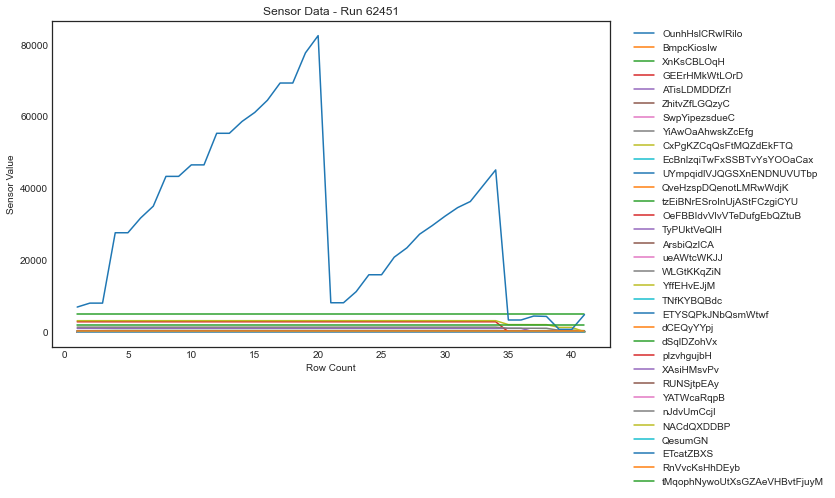

In [19]:
run_number = 62451  # Specify the run number you want to plot

plt.figure(figsize=(10, 6))  # Set the figure size
plt.title(f'Sensor Data - Run {run_number}')  # Set the title

for sensor in sensors:
    # Filter the data for the specific run and sensor
    data = df[df['Run'] == run_number][sensor]
    row_count = range(1, len(data) + 1)

    plt.plot(row_count, data, label=sensor)  # Plot the line for the sensor

plt.xlabel('Row Count')
plt.ylabel('Sensor Value')
plt.legend(bbox_to_anchor=(1.4, 1), loc='upper right')  # Show the legend with sensor names
plt.show()

Since the min and max are very different for each sensor, we will scale the sensor values using StandardScaler.

In [20]:
# Create a copy of the DataFrame
scaled_df = df.copy()

# Create the ColumnTransformer with RobustScaler for sensor columns
transformer = ColumnTransformer(
    transformers=[('scaler', StandardScaler(), sensors)],  # MinMaxScaler, StandardScaler, RobustScaler
    remainder='passthrough'  # Pass through the remaining columns without scaling
)

# Apply the transformation to the selected columns
scaled_df[sensors] = transformer.fit_transform(df[sensors])

In [21]:
scaled_df.head()

TimeStamp    Run RunStartTime  DATA_QUALITY LOT_ID MachineRecipeID  \
1  21/3/2023 19:14  62301  12:14:19 AM         63.49      A               A   
2  21/3/2023 19:14  62301  12:14:19 AM         63.49      A               A   
3  21/3/2023 19:14  62301  12:14:19 AM         63.49      A               A   
4  21/3/2023 19:14  62301  12:14:19 AM         63.49      A               A   
5  21/3/2023 19:14  62301  12:14:19 AM         63.49      A               A   

  PhysicalRecipeID PortID ProcessOpNum ProductGrpID  ... RUNSjtpEAy  \
1                A      A            A            A  ...  -0.589741   
2                A      A            A            A  ...   0.503794   
3                A      A            A            A  ...   0.139282   
4                A      A            A            A  ...  -0.042974   
5                A      A            A            A  ...  -0.225229   

  YATWcaRqpB nJdvUmCcjI NACdQXDDBP   QesumGN  ETcatZBXS  RnVvcKsHhDEyb  \
1  -0.462556  -3.594964  -3.303095 -2.267766  -1.052805      -1.435227   
2   0.177114   0.393999   0.443958 -1.277225  -1.061203      -1.435227   
3   0.049180   0.397058   0.440343 -1.079117  -1.061203      -1.435227   
4  -0.078754   0.387881   0.436729 -0.881009  -0.813475      -1.435227   
5  -0.206688   0.387881   0.435524 -0.484792  -1.015016      -1.435227   

   tMqophNywoUtXsGZAeVHBvtFjuyM  CalcStepSeq  CalcLoopSeq  
1                     -6.128276          1.0          1.0  
2                      0.169165          2.0          2.0  
3                      0.169165          3.0          3.0  
4                      0.169165          4.0          4.0  
5                      0.169165          5.0          5.0  

[5 rows x 50 columns]

In [22]:
min_values = scaled_df[sensors].min()
max_values = scaled_df[sensors].max()

print("Minimum:", min_values.min())
print()
print("Maximum:", max_values.max())

Minimum: -32.23579324762245

Maximum: 28.38894940757859


Plot the sensor values for a specific run to see the distribution of the values again.

In [23]:
run_number = 62451  # Specify the run number you want to plot

plt.figure(figsize=(10, 6))  # Set the figure size
plt.title(f'Sensor Data - Run {run_number}')  # Set the title

for sensor in sensors:
    # Filter the data for the specific run and sensor
    data = scaled_df[scaled_df['Run'] == run_number][sensor]
    row_count = range(1, len(data) + 1)

    plt.plot(row_count, data, label=sensor)  # Plot the line for the sensor

plt.xlabel('Row Count')
plt.ylabel('Sensor Value')
plt.legend(bbox_to_anchor=(1.4, 1), loc='upper right')  # Show the legend with sensor names
plt.show()

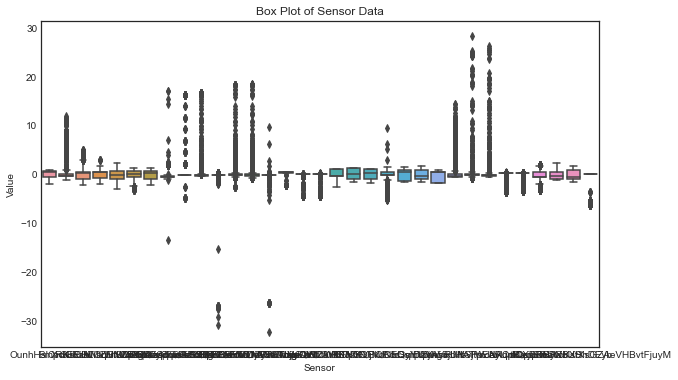

In [24]:
# Set the figure size
plt.figure(figsize=(10, 6))  # Adjust the width and height as desired

# Create the box plot using Seaborn
sns.boxplot(data=scaled_df[sensors])

# Add labels and title
plt.xlabel('Sensor')
plt.ylabel('Value')
plt.title('Box Plot of Sensor Data')

# Show the plot
plt.show()

## Group by Run
Since the task is to predict whether a wafer run is anomalous or not, we will assume that if any of the sensors at any time are anomalous, the entire run (wafer) is anomalous.

Group the data by run and take the mean of each sensor value for each run.

In [25]:
# Value counts (rows) of each run sort by run number
df['Run'].value_counts().loc[df['Run'].unique()]

62301    59
62302    63
62303    59
62304    54
62305    60
         ..
62596    49
62597    61
62598    54
62599    79
62600    66
Name: Run, Length: 228, dtype: int64

In [26]:
# Group by run and take the mean of each sensor value
df_run = df.groupby('Run').mean()
df_run.head(10)

DATA_QUALITY  WAFER_ID  OunhHslCRwIRilo  BmpcKiosIw  XnKsCBLOqH  \
Run                                                                      
62301         63.49         1       113.525424    5.313051  351.169492   
62302         65.71         4       113.857143    5.824127  345.507937   
62303         62.82         7        97.644068    5.247966  353.084746   
62304         57.50        10       118.611111    5.109630  356.185185   
62305         63.89        13       111.883333    6.944833  347.533333   
62306         67.47        16        93.393939    5.435303  351.530303   
62307         58.56        19       118.909091    5.223636  356.527273   
62308         68.15        22       111.843750    6.545469  346.250000   
62309         59.18        25        99.454545    5.196182  352.527273   
62318         59.71         2       103.847458    5.167288  360.322034   

       GEErHMkWtLOrD  ATisLDMDDfZrI  ZhitvZfLGQzyC  SwpYipezsdueC  \
Run                                                                 
62301     119.474576     130.423729     150.559322     132.101695   
62302     119.682540     127.428571     137.031746     131.571429   
62303     119.677966     127.661017     145.525424     131.542373   
62304     119.574074     130.111111     150.407407     132.148148   
62305     119.566667     127.300000     135.816667     130.683333   
62306     119.742424     128.181818     146.181818     131.848485   
62307     119.490909     129.818182     149.872727     131.545455   
62308     119.625000     127.343750     136.250000     131.203125   
62309     119.654545     128.109091     145.981818     131.018182   
62318     119.661017     128.372881     146.627119     132.372881   

       YiAwOaAhwskZcEfg  ...  RUNSjtpEAy  YATWcaRqpB   nJdvUmCcjI  \
Run                      ...                                        
62301        -63.000000  ...    6.084746    3.118644  1204.966102   
62302        -57.269841  ...    7.904762    3.714286  1136.380952   
62303        -65.474576  ...    5.508475    3.644068  1226.169492   
62304        -60.388889  ...    5.277778    3.629630  1187.685185   
62305        -60.300000  ...    6.516667    5.066667  1195.066667   
62306        -62.742424  ...    5.227273    2.484848  1177.696970   
62307        -63.454545  ...    6.018182    3.890909  1219.054545   
62308        -60.078125  ...    5.859375    3.937500  1169.531250   
62309        -63.254545  ...    5.181818    2.909091  1218.618182   
62318        -61.474576  ...    5.610169    2.610169  1180.559322   

        NACdQXDDBP    QesumGN     ETcatZBXS  RnVvcKsHhDEyb  \
Run                                                          
62301  2826.000000  14.135593  25228.813559      81.000000   
62302  2640.650794  12.539683  21130.158730      81.000000   
62303  2883.745763  13.694915  25698.305085      81.000000   
62304  2768.055556  14.518519  25757.407407      81.000000   
62305  2770.883333  12.483333  24655.000000      81.000000   
62306  2770.227273  12.575758  24893.939394      81.000000   
62307  2860.290909  13.890909  26534.545455      81.000000   
62308  2710.296875  12.218750  24912.500000      81.000000   
62309  2854.472727  13.745455  23336.363636      81.690909   
62318  2783.084746  13.186441  23810.169492      82.000000   

       tMqophNywoUtXsGZAeVHBvtFjuyM  CalcStepSeq  CalcLoopSeq  
Run                                                            
62301                   1857.542373     6.000000     6.000000  
62302                   1772.380952     6.809524     6.809524  
62303                   1890.000000     4.830508     4.830508  
62304                   1890.000000     4.351852     4.351852  
62305                   1766.500000     7.216667     7.216667  
62306                   1890.000000     6.060606     6.060606  
62307                   1890.000000     5.927273     5.927273  
62308                   1774.218750     8.109375     8.109375  
62309                   1890.000000     4.727273     4.727273  
62318      

In [27]:
df_run.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228 entries, 62301 to 62600
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   DATA_QUALITY                  228 non-null    float64
 1   WAFER_ID                      228 non-null    int64  
 2   OunhHslCRwIRilo               228 non-null    float64
 3   BmpcKiosIw                    228 non-null    float64
 4   XnKsCBLOqH                    228 non-null    float64
 5   GEErHMkWtLOrD                 228 non-null    float64
 6   ATisLDMDDfZrI                 228 non-null    float64
 7   ZhitvZfLGQzyC                 228 non-null    float64
 8   SwpYipezsdueC                 228 non-null    float64
 9   YiAwOaAhwskZcEfg              228 non-null    float64
 10  CxPgKZCqQsFtMQZdEkFTQ         228 non-null    float64
 11  EcBnlzqiTwFxSSBTvYsYOOaCax    228 non-null    float64
 12  UYmpqidlVJQGSXnENDNUVUTbp     228 non-null    float64
 13 

Scale the sensor values (mean) again.

Standardization (Z-score normalization):
Formula: X_scaled = (X - X_mean) / X_std
This method transforms the data to have a mean of 0 and standard deviation of 1.
It is less sensitive to outliers compared to Min-Max Scaling.
It allows negative values and can handle both positive and negative skewness.

In [28]:
# Create a copy of the DataFrame
scaled_df_run = df_run.copy()

# Create the ColumnTransformer with RobustScaler for sensor columns
transformer = ColumnTransformer(
    transformers=[('scaler', StandardScaler(), sensors)],  # MinMaxScaler, StandardScaler, RobustScaler
    remainder='passthrough'  # Pass through the remaining columns without scaling
)

# Apply the transformation to the selected columns
scaled_df_run[sensors] = transformer.fit_transform(df_run[sensors])

In [29]:
min_values = scaled_df_run[sensors].min()
max_values = scaled_df_run[sensors].max()

print("Minimum:", min_values.min())
print()
print("Maximum:", max_values.max())

Minimum: -10.004742239722273

Maximum: 14.712318037017594


Plot the mean of each sensor value.

array([[<AxesSubplot:xlabel='Run'>, <AxesSubplot:xlabel='Run'>,
        <AxesSubplot:xlabel='Run'>, <AxesSubplot:xlabel='Run'>,
        <AxesSubplot:xlabel='Run'>],
       [<AxesSubplot:xlabel='Run'>, <AxesSubplot:xlabel='Run'>,
        <AxesSubplot:xlabel='Run'>, <AxesSubplot:xlabel='Run'>,
        <AxesSubplot:xlabel='Run'>],
       [<AxesSubplot:xlabel='Run'>, <AxesSubplot:xlabel='Run'>,
        <AxesSubplot:xlabel='Run'>, <AxesSubplot:xlabel='Run'>,
        <AxesSubplot:xlabel='Run'>],
       [<AxesSubplot:xlabel='Run'>, <AxesSubplot:xlabel='Run'>,
        <AxesSubplot:xlabel='Run'>, <AxesSubplot:xlabel='Run'>,
        <AxesSubplot:xlabel='Run'>],
       [<AxesSubplot:xlabel='Run'>, <AxesSubplot:xlabel='Run'>,
        <AxesSubplot:xlabel='Run'>, <AxesSubplot:xlabel='Run'>,
        <AxesSubplot:xlabel='Run'>],
       [<AxesSubplot:xlabel='Run'>, <AxesSubplot:xlabel='Run'>,
        <AxesSubplot:xlabel='Run'>, <AxesSubplot:xlabel='Run'>,
        <AxesSubplot:xlabel='Run'>],
       [<A

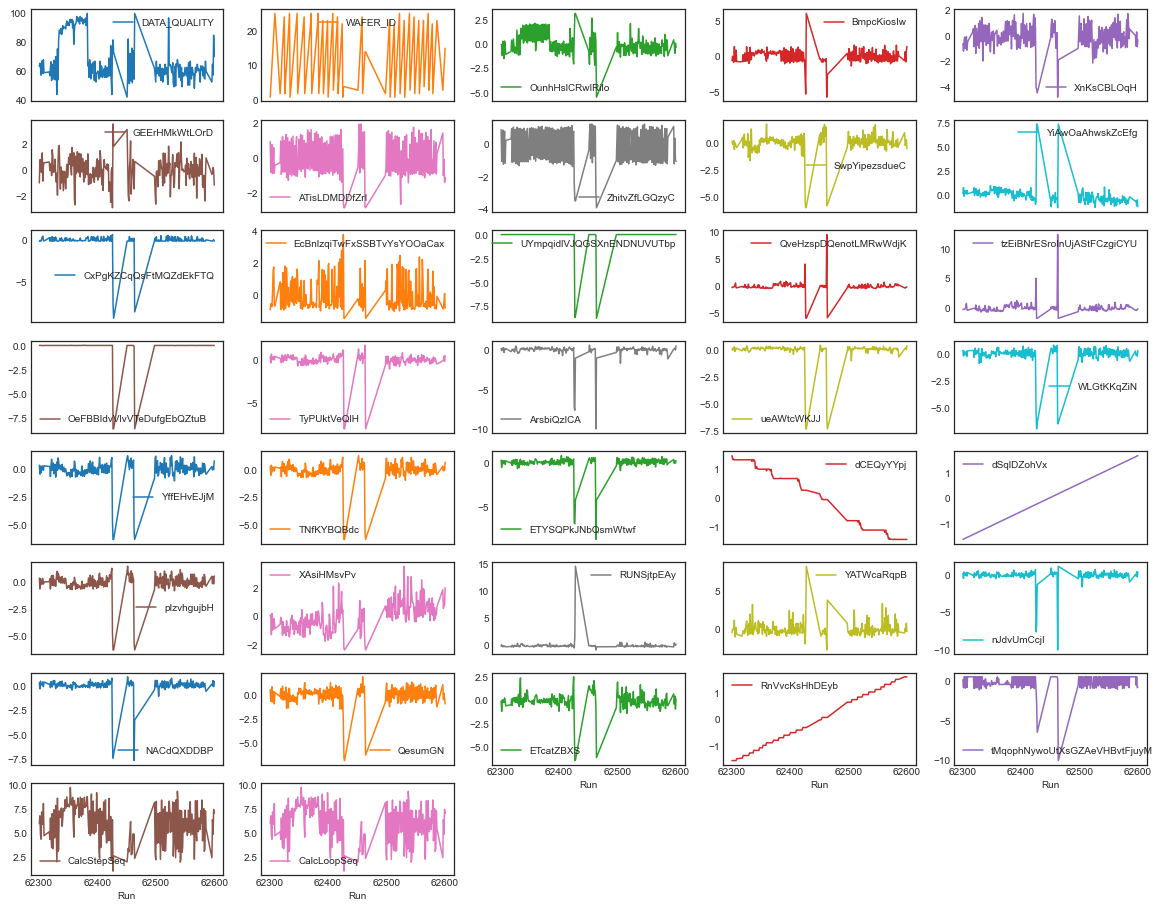

In [30]:
# Plot the mean of each sensor value for each run
scaled_df_run.plot(subplots=True, figsize=(20, 20), layout=(10, 5))

From above, it is observed that for some run, the sensor mean value behaves differently from other runs.

Plot a box plot of the scaled sensor mean values.

In [31]:
# Set the figure size
plt.figure(figsize=(10, 6))  # Adjust the width and height as desired

# Create the box plot using Seaborn
sns.boxplot(data=scaled_df_run[sensors])

# Add labels and title
plt.xlabel('Sensor')
plt.ylabel('Value')
plt.title('Box Plot of Sensor Data')

# Show the plot
plt.show()

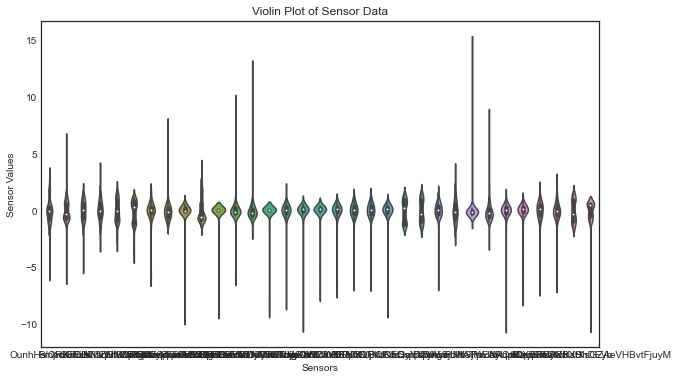

In [32]:
# Set the figure size
plt.figure(figsize=(10, 6))  # Adjust the width and height as desired

# Create a violin plot
sns.violinplot(data=scaled_df_run[sensors])

# Set the plot title and axes labels
plt.title('Violin Plot of Sensor Data')
plt.xlabel('Sensors')
plt.ylabel('Sensor Values')

# Show the plot
plt.show()

From above, it is observed that the scaled sensor mean values are more or less in the same range, with some outliers.

Plot the correlation matrix and scatter plots for the scaled sensor mean values.

In [33]:
# Calculate the correlation matrix
correlation_matrix = scaled_df_run[sensors].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))  # Adjust the width and height as desired

sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')

# Add title
plt.title('Correlation Between Sensor Values')

# Show the plot
plt.show()

In [34]:
# Create a subset of the DataFrame with only the sensor columns
subset_data = scaled_df_run[sensors]

# Plot scatter plots for all pairs of sensor columns
sns.pairplot(subset_data)

# Show the plot
plt.show()

There seems to be a strong correlation between some of the sensor values from the heatmap generated.

# Anomaly Detection
Since there are no labels (normal / anomalous) associated with the sensor data, supervised learning is not feasible.
Therefore, we will use unsupervised learning to detect anomalies in the sensor data.

Assuming that if a run is anomalous, at least one of the sensor values will be anomalous, meaning that it will be outside the normal range of values.

We will use the z-score method to detect anomalies.

In [35]:
# Create empty DataFrame to store results later
results = pd.DataFrame(df_run.index, columns=['Run'])

## Z-score method
Z-score is a statistical measure that quantifies how many standard deviations a data point is away from the mean of a distribution. It is commonly used to identify outliers in a dataset.

If the z-score is greater than a threshold, label the run as anomalous. Otherwise, label the run as normal.

The threshold is the number of standard deviations from the mean that a value must be to be considered an anomaly. The higher the threshold, the more sensitive the anomaly detection.

We will use a threshold of 3. This means that if a sensor value is more than 3 standard deviations from the mean, it will be considered an anomaly. This is a common threshold used for anomaly detection.

In [36]:
# Calculate the z-score for each sensor value in each run.
z_scores = np.abs((df_run[sensors] - df_run[sensors].mean()) / df_run[sensors].std())
# we don't use the scaled data here

In [37]:
# Set a threshold for the z-score, such as 3 (you can adjust this as needed)
threshold = 3

# Set the minimum number of columns (sensors) with outliers required to label as 'Anomaly'
min_outlier_columns = 1

# Count the number of columns with z-scores greater than a threshold
outlier_counts = z_scores.gt(threshold).sum(axis=1)

# Create a new column in results to store the z-scores results, 1 if normal, 0 if anomalous.
results['Z-score'] = np.where(outlier_counts >= min_outlier_columns, -1, 1)

In [38]:
results['Z-score'].value_counts()

 1    219
-1      9
Name: Z-score, dtype: int64

9/228 = about 4% of the runs are anomalous.

##  Isolation Forest
Isolation Forest is an unsupervised learning algorithm that is based on the Decision Tree algorithm. It is used for anomaly detection and is based on the observation that anomalies are data points that are few and different.

Isolation Forest works by creating isolation trees, which are binary trees that recursively split the data into subsets. The algorithm randomly selects a feature and a random split value within the range of that feature's values. It continues this process until it isolates the anomalies, which are expected to require fewer splits compared to normal instances.

In [39]:
# Create a subset of the DataFrame with only the sensor columns
X = scaled_df_run[sensors]

Assuming the Z-score method is the ground truth, we will use a contamination value of 0.05, which assumed that 5% of the data are anomalies.

In [40]:
model=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.05),max_features=1.0, random_state=42)
#model=IsolationForest()
model.fit(X)

IsolationForest(contamination=0.05, n_estimators=50, random_state=42)

In [41]:
#X_sensors['scores']=model.decision_function(X_sensors)
results['IsoF']=model.predict(X)

In [42]:
results['IsoF'].value_counts()

 1    216
-1     12
Name: IsoF, dtype: int64

In [43]:
print(classification_report(results['Z-score'], results['IsoF']))

              precision    recall  f1-score   support

          -1       0.42      0.56      0.48         9
           1       0.98      0.97      0.97       219

    accuracy                           0.95       228
   macro avg       0.70      0.76      0.73       228
weighted avg       0.96      0.95      0.96       228



### Explainability using SHAP
Link: https://pub.towardsai.net/interpretation-of-isolation-forest-with-shap-d1b6af93ae71#0985

In [50]:
# Define the explainer object
explainer = shap.Explainer(model.predict, X)
shap_values = explainer(X)

Permutation explainer: 229it [01:19,  2.52it/s]                         


In [51]:
# Load JS library
shap.initjs()

#### Explain Single Prediction

In [52]:
results[results['IsoF'] == -1]

Run  Z-score  IsoF
20   62329        1    -1
23   62332        1    -1
114  62423        1    -1
117  62426       -1    -1
118  62427       -1    -1
119  62428       -1    -1
132  62463       -1    -1
133  62464       -1    -1
141  62505        1    -1
163  62527        1    -1
187  62551        1    -1
227  62600        1    -1

In [53]:
# Plot outcome of anomalous run
shap.plots.force(shap_values[141])

The predicted value is -1, which means that the run is anomalous.
The base value is 0.88, which is the average of the target variable across all the rows of the dataset.

In [54]:
# Plot outcome of a normal run
shap.plots.force(shap_values[0])

More red means more normal.

In [55]:
# Easier to read with waterfall plot
shap.plots.waterfall(shap_values[141])

This plot visualize the impact of each feature on the prediction. The features are listed in descending order of importance.

#### Explain Single Feature

In [56]:
shap.plots.scatter(shap_values[:,'NACdQXDDBP'], color=shap_values)

It is observed that the outliers of the feature NACdQXDDBP which are further away from the center cluster are more likely to be anomalous (marked in blue).

#### Global Interpretability

In [57]:
shap.summary_plot(shap_values, X)

In [58]:
shap.plots.bar(shap_values, max_display=11)

The above plot shows the top 10 features that are most important in determining whether a run is anomalous or not.

## Local Outlier Factor
Local Outlier Factor (LOF) is an unsupervised learning algorithm that is based on the idea that the local density of a point is different from the local densities of its neighbors. An anomaly is a point that has a substantially lower density than its neighbors.

In [59]:
model = LocalOutlierFactor(n_neighbors=20, algorithm='auto', leaf_size=30, metric='minkowski', p=2, metric_params=None, contamination=0.05, novelty=False, n_jobs=-1)
model.fit(X)

LocalOutlierFactor(contamination=0.05, n_jobs=-1)

In [60]:
results['LOF']=model.fit_predict(X)

In [61]:
results['LOF'].value_counts()

 1    216
-1     12
Name: LOF, dtype: int64

In [62]:
print(classification_report(results['Z-score'], results['LOF']))

              precision    recall  f1-score   support

          -1       0.67      0.89      0.76         9
           1       1.00      0.98      0.99       219

    accuracy                           0.98       228
   macro avg       0.83      0.94      0.88       228
weighted avg       0.98      0.98      0.98       228



## One Class SVM

One Class SVM is a type of SVM algorithm that is used for outlier detection. It is based on the idea that the training dataset contains only normal instances. It learns a decision boundary that separates the normal instances from the outliers.

To do this the outlier rows need to be filtered out, assuming the z-score method is the ground truth.

In [63]:
# Filter out outliers row
zscore_df = scaled_df_run[outlier_counts == 0]

In [64]:
model = OneClassSVM(kernel='linear', degree=3, gamma=0.1,nu=0.05, max_iter=-1)
model.fit(zscore_df[sensors])

OneClassSVM(gamma=0.1, kernel='linear', nu=0.05)

In [65]:
results['OC_SVM']=model.predict(X)

In [66]:
results['OC_SVM'].value_counts()

 1    206
-1     22
Name: OC_SVM, dtype: int64

In [67]:
print(classification_report(results['Z-score'], results['OC_SVM']))

              precision    recall  f1-score   support

          -1       0.27      0.67      0.39         9
           1       0.99      0.93      0.96       219

    accuracy                           0.92       228
   macro avg       0.63      0.80      0.67       228
weighted avg       0.96      0.92      0.93       228



# Results
We gathered the results from all the models. We then combined the results by counting the number of models that flagged a run as an anomaly. The more models that flagged a run as an anomaly, the more likely it is that the data point is an anomaly.

Assuming anomalous runs are flagged by at least 3 models. (Adjustable)

In [82]:
results['Anomaly_Score'] = results[['Z-score', 'IsoF', 'LOF', 'OC_SVM']].apply(lambda x: (x == -1).sum(), axis=1)
results['Anomaly_Label'] = results['Anomaly_Score'].apply(lambda x: 'Anomaly' if x >= 3 else 'Normal')
results.head(10)

Run  Z-score  IsoF  LOF  OC_SVM  Anomaly_Score Anomaly_Label
0  62301        1     1    1       1              0        Normal
1  62302        1     1    1       1              0        Normal
2  62303        1     1    1       1              0        Normal
3  62304        1     1    1      -1              1        Normal
4  62305        1     1    1       1              0        Normal
5  62306        1     1    1       1              0        Normal
6  62307        1     1    1       1              0        Normal
7  62308        1     1    1       1              0        Normal
8  62309        1     1    1       1              0        Normal
9  62318        1     1    1       1              0        Normal

In [83]:
results['Anomaly_Score'].value_counts()

0    196
1     21
4      5
2      4
3      2
Name: Anomaly_Score, dtype: int64

The following runs are flagged as anomalous:

In [84]:
# Answer
results[results['Anomaly_Label'] == 'Anomaly']['Run']

117    62426
118    62427
119    62428
120    62451
132    62463
133    62464
141    62505
Name: Run, dtype: int64

In [85]:
# Check runs that are flagged by three other models except Z-score
results[(results['Anomaly_Score'] == 3) & results['Z-score'] == 1]['Run']

120    62451
141    62505
Name: Run, dtype: int64

In [86]:
# Create a new dataframe with the scaled sensor data and the anomaly results
temp = df_run.reset_index().copy()
sensor_subset = temp[['Run'] + sensors.tolist()]
merged_df = sensor_subset.merge(results, on='Run')
merged_df.head(10)

Run  OunhHslCRwIRilo  BmpcKiosIw  XnKsCBLOqH  GEErHMkWtLOrD  \
0  62301       113.525424    5.313051  351.169492     119.474576   
1  62302       113.857143    5.824127  345.507937     119.682540   
2  62303        97.644068    5.247966  353.084746     119.677966   
3  62304       118.611111    5.109630  356.185185     119.574074   
4  62305       111.883333    6.944833  347.533333     119.566667   
5  62306        93.393939    5.435303  351.530303     119.742424   
6  62307       118.909091    5.223636  356.527273     119.490909   
7  62308       111.843750    6.545469  346.250000     119.625000   
8  62309        99.454545    5.196182  352.527273     119.654545   
9  62318       103.847458    5.167288  360.322034     119.661017   

   ATisLDMDDfZrI  ZhitvZfLGQzyC  SwpYipezsdueC  YiAwOaAhwskZcEfg  \
0     130.423729     150.559322     132.101695        -63.000000   
1     127.428571     137.031746     131.571429        -57.269841   
2     127.661017     145.525424     131.542373        -65.474576   
3     130.111111     150.407407     132.148148        -60.388889   
4     127.300000     135.816667     130.683333        -60.300000   
5     128.181818     146.181818     131.848485        -62.742424   
6     129.818182     149.872727     131.545455        -63.454545   
7     127.343750     136.250000     131.203125        -60.078125   
8     128.109091     145.981818     131.018182        -63.254545   
9     128.372881     146.627119     132.372881        -61.474576   

   CxPgKZCqQsFtMQZdEkFTQ  ...    QesumGN     ETcatZBXS  RnVvcKsHhDEyb  \
0               3.000000  ...  14.135593  25228.813559      81.000000   
1               3.015873  ...  12.539683  21130.158730      81.000000   
2               3.000000  ...  13.694915  25698.305085      81.000000   
3               3.000000  ...  14.518519  25757.407407      81.000000   
4               3.050000  ...  12.483333  24655.000000      81.000000   
5               3.106061  ...  12.575758  24893.939394      81.000000   
6               3.127273  ...  13.890909  26534.545455      81.000000   
7               3.015625  ...  12.218750  24912.500000      81.000000   
8               3.000000  ...  13.745455  23336.363636      81.690909   
9               3.084746  ...  13.186441  23810.169492      82.000000   

   tMqophNywoUtXsGZAeVHBvtFjuyM  Z-score  IsoF  LOF  OC_SVM  Anomaly_Score  \
0                   1857.542373        1     1    1       1              0   
1                   1772.380952        1     1    1       1              0   
2                   1890.000000        1     1    1       1              0   
3                   1890.000000        1     1    1      -1              1   
4                   1766.500000        1     1    1       1              0   
5                   1890.000000        1     1    1       1              0   
6                   1890.000000        1     1    1       1              0   
7                   1774.218750        1     1    1       1              0   
8                   1890.000000        1     1    1       1              0   
9                   1890.000000        1     1    1       1              0   

   Anomaly_Label  
0         Normal  
1         Normal  
2         Normal  
3         Normal  
4         Normal  
5         Normal  
6         Normal  
7         Normal  
8         Normal  
9         Normal  

[10 rows x 40 columns]

## Visualizing the outliers detected in each sensor

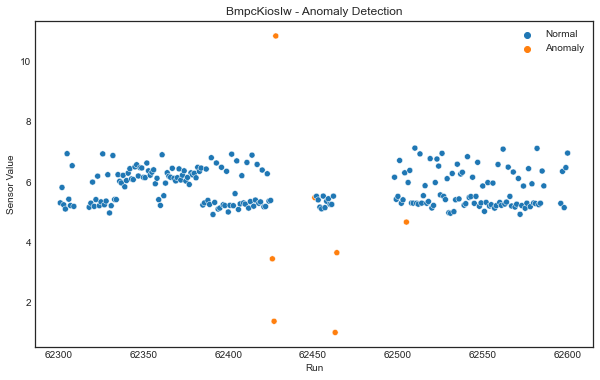

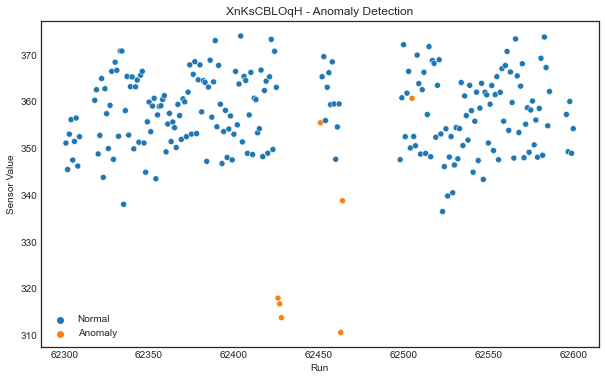

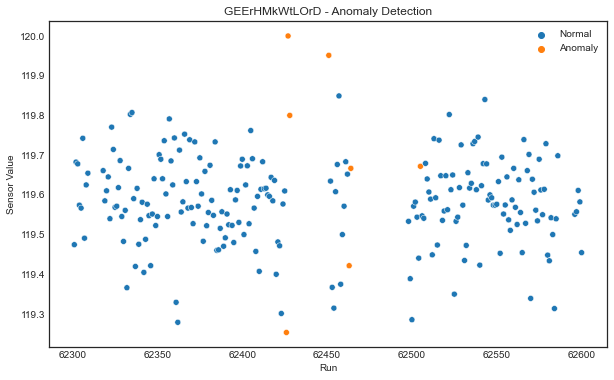

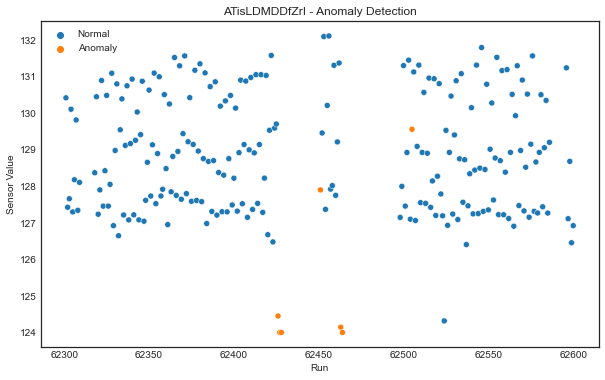

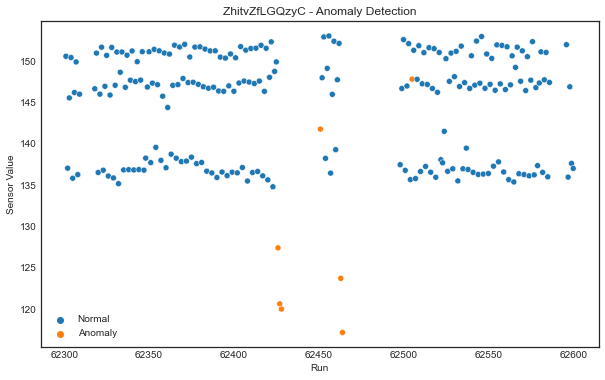

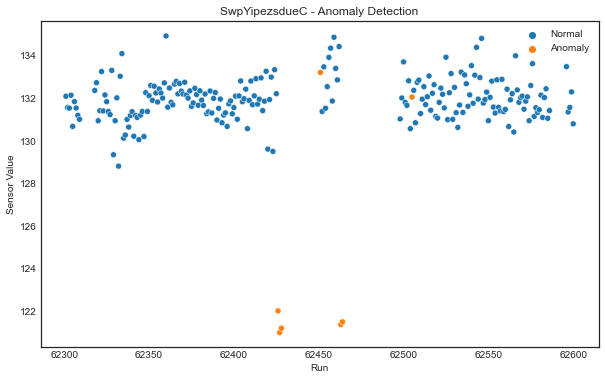

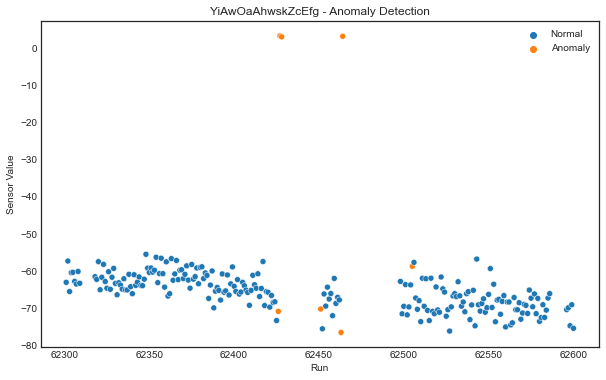

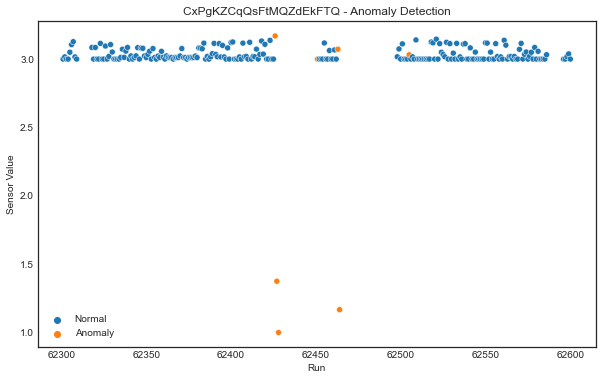

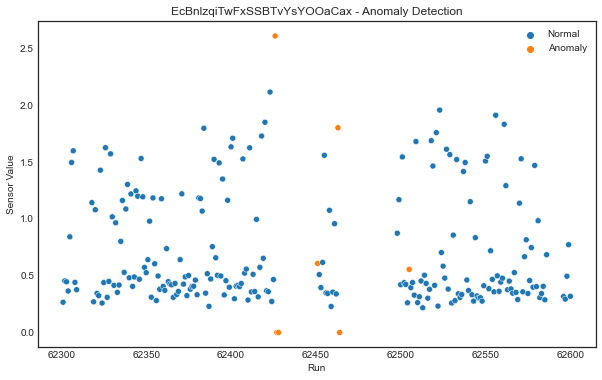

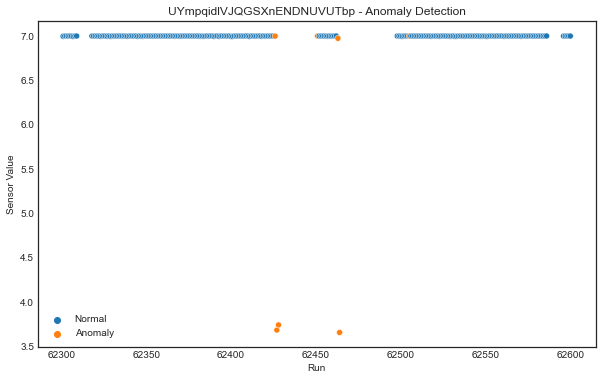

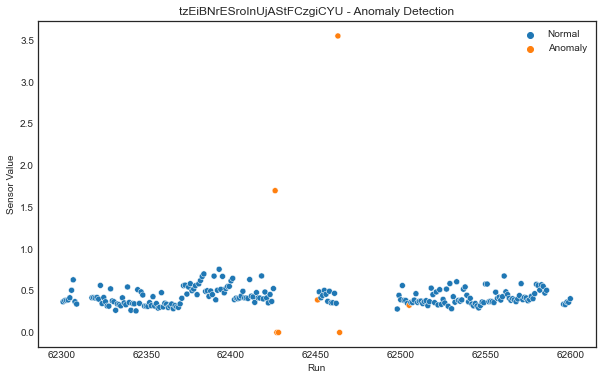

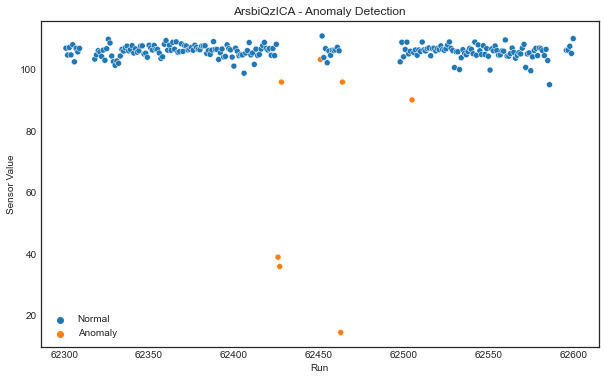

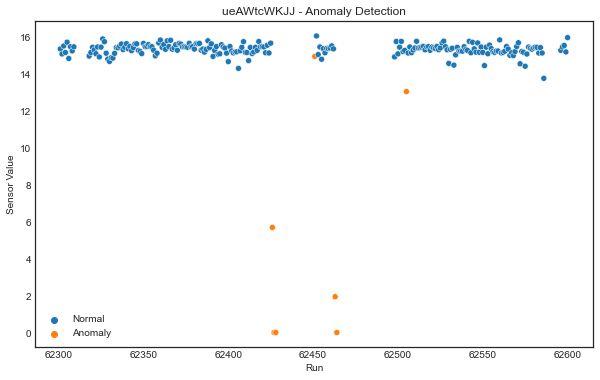

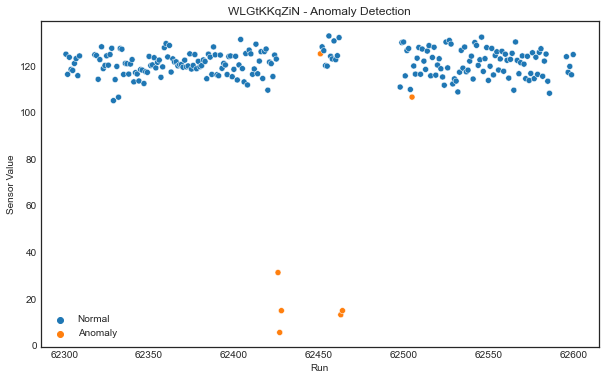

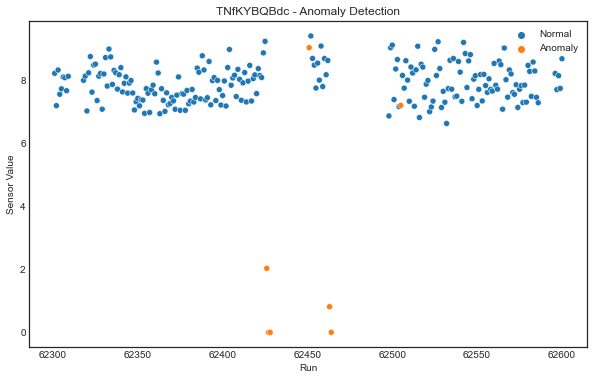

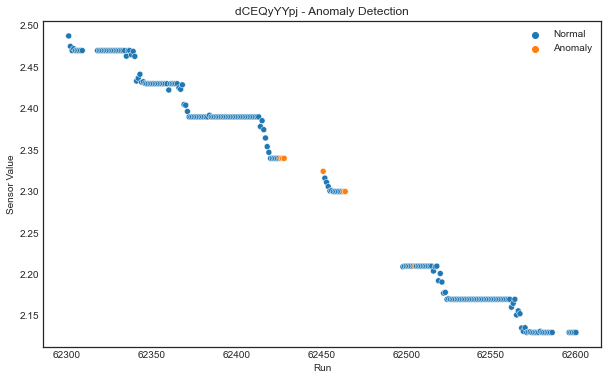

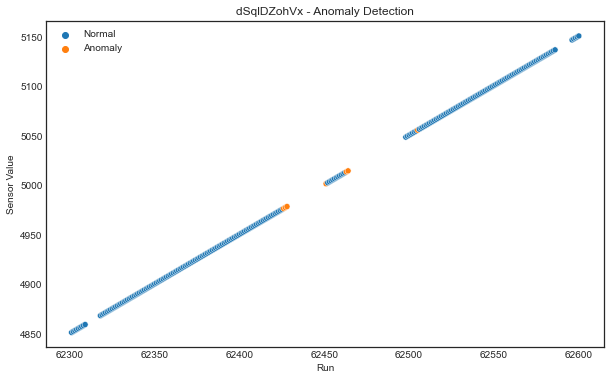

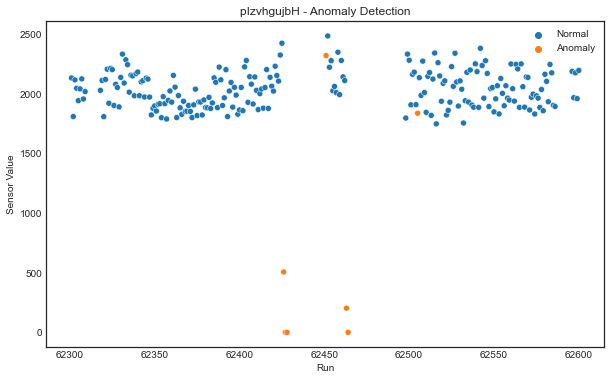

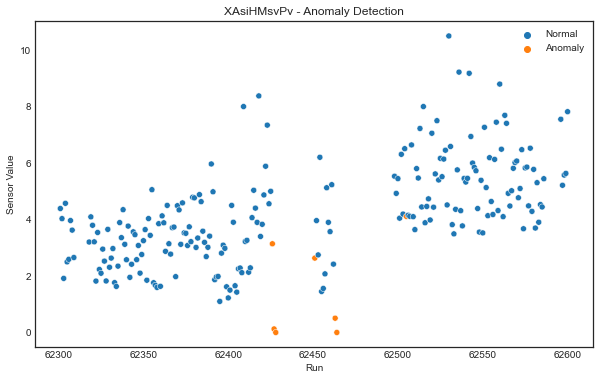

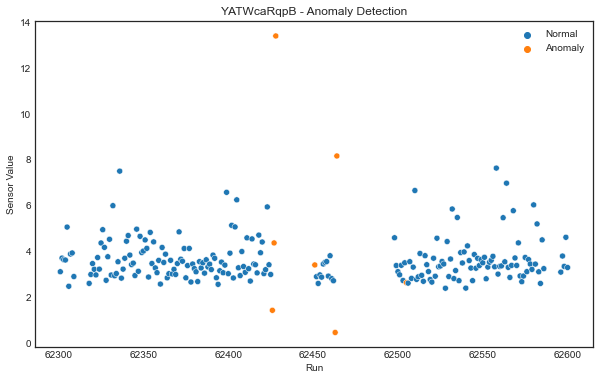

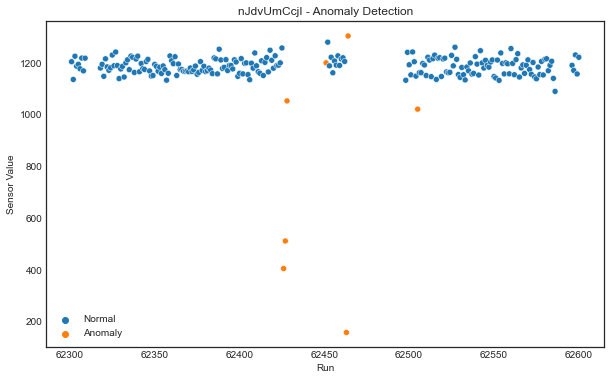

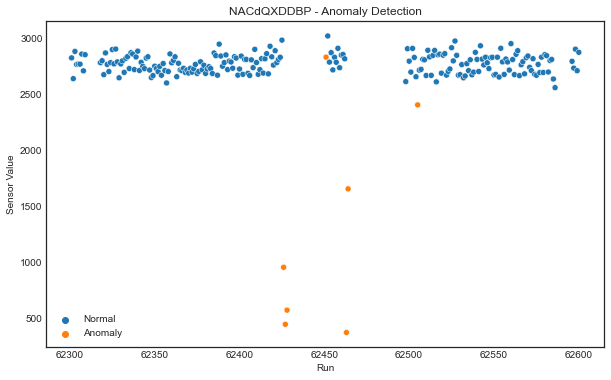

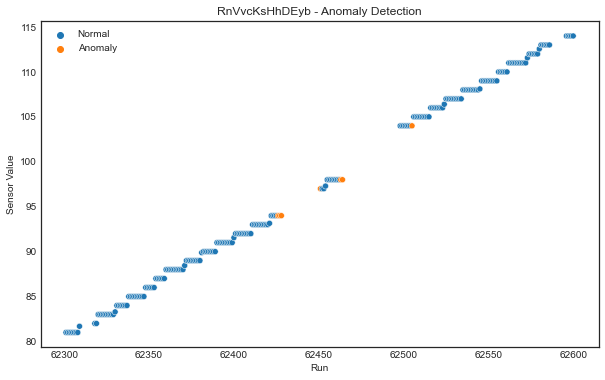

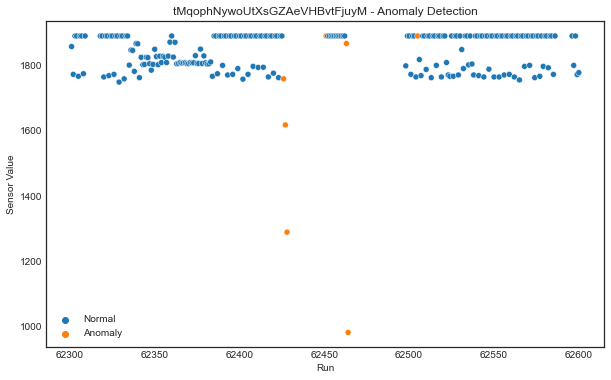

In [87]:
# Iterate over each sensor column and plot the graph with anomaly highlighting
for column in merged_df.columns[1:-6]:  # Exclude the 'anomaly_label' column
    plt.figure(figsize=(10, 6))  # Adjust the figure size as per your preference
    sns.scatterplot(data=merged_df, x='Run', y=column, hue='Anomaly_Label')
    plt.title(f'{column} - Anomaly Detection')
    plt.xlabel('Run')
    plt.ylabel('Sensor Value')
    plt.legend()
    plt.show()

From the visualizations, we can see that the anomalies (outliers), marked in orange, are detected.

In [88]:
results.to_csv('results.csv')